# AN2DL - Second Challenge

## Initial Operations

### Import the libraries

In [5]:
import tensorflow as tf
import numpy as np
import os
import random
import pandas as pd
import seaborn as sns
from datetime import datetime
import matplotlib.pyplot as plt
plt.rc('font', size=16)
from sklearn.preprocessing import MinMaxScaler
from attention import Attention
import warnings
warnings.filterwarnings('ignore')
tf.get_logger().setLevel('ERROR')

tfk = tf.keras
tfkl = tf.keras.layers

### Set seed for reproducibility

In [6]:
seed = 69
random.seed(seed)
os.environ['PYTHONHASHSEED'] = str(seed)
np.random.seed(seed)
tf.random.set_seed(seed)
tf.compat.v1.set_random_seed(seed)

### Load the dataset

In [7]:
dataset = pd.read_csv('training.csv')
print(dataset.shape)
dataset.head()

(68528, 7)


,Sponginess,Wonder level,Crunchiness,Loudness on impact,Meme creativity,Soap slipperiness,Hype root
0,7.97698,4.33494,10.67282,1.76692,3.22440,51.681460,3.65434
1,8.07824,4.44616,10.56160,1.70716,3.32566,51.563598,3.47672
2,8.02844,4.22372,10.56160,1.64906,3.17460,50.863080,3.47672
3,8.02844,4.22372,10.56160,1.70716,3.17460,45.841581,3.47672
4,7.87572,4.44616,10.45038,1.70716,3.27586,47.126421,3.47672


## Model (Autoregression)

### Normalization

In [8]:
X_train_raw = dataset.copy()

# Normalize both train and test samples
X_min = X_train_raw.min()
X_max = X_train_raw.max()
X_train_raw = (X_train_raw-X_min)/(X_max-X_min)

### Define sequences

In [9]:
target_labels = dataset.columns
window = 100
stride = 10
telescope = 54

In [10]:
def build_sequences(df, target_labels=['pollution'], window=200, stride=20, telescope=100):
    # Sanity check to avoid runtime errors
    assert window % stride == 0
    dataset = []
    labels = []
    temp_df = df.copy().values
    temp_label = df[target_labels].copy().values
    padding_len = len(df)%window

    if(padding_len != 0):
        # Compute padding length
        padding_len = window - len(df)%window
        padding = np.zeros((padding_len,temp_df.shape[1]), dtype='float64')
        temp_df = np.concatenate((padding,df))
        padding = np.zeros((padding_len,temp_label.shape[1]), dtype='float64')
        temp_label = np.concatenate((padding,temp_label))
        assert len(temp_df) % window == 0

    for idx in np.arange(0,len(temp_df)-window-telescope,stride):
        dataset.append(temp_df[idx:idx+window])
        labels.append(temp_label[idx+window:idx+window+telescope])

    dataset = np.array(dataset)
    labels = np.array(labels)
    return dataset, labels

In [11]:
X_train, y_train = build_sequences(X_train_raw, target_labels, window, stride, telescope)

### Define the model

In [12]:
input_shape = X_train.shape[1:]
output_shape = y_train.shape[1:]
batch_size = 64
epochs = 200

In [13]:
def build_model(input_shape, output_shape):
    # Build the neural network layer by layer
    input_layer = tfkl.Input(shape=input_shape, name='Input')

    # Convolutional Layer
    convolutional = tfkl.Conv1D(128, 3, padding='same', activation='relu')(input_layer)
    # convolutional = tfkl.MaxPool1D()(convolutional)

    # Recurrent Layer
    recurrent = tfkl.Bidirectional(tfkl.GRU(128, return_sequences=True, activation='relu'))(convolutional)

    # Skip-Recurrent Layer
    skip_recurrent1 = tfkl.Bidirectional(tfkl.LSTM(32, return_sequences=True))(convolutional)
    skip_recurrent2 = tfkl.Bidirectional(tfkl.LSTM(32, return_sequences=True))(skip_recurrent1)
    add = tfkl.Add()([skip_recurrent1,skip_recurrent2])
    skip_recurrent3 = tfkl.Bidirectional(tfkl.LSTM(128, return_sequences=True))(add)

    # Add and Dropout Layer
    add = tfkl.Add()([recurrent,skip_recurrent3])
    add = tfkl.GlobalAveragePooling1D()(add)
    dropout = tfkl.Dropout(.3)(add)
    

    # Output Layer
    dense = tfkl.Dense(output_shape[-1]*output_shape[-2], activation='relu')(dropout)
    output_layer = tfkl.Reshape((output_shape[-2],output_shape[-1]))(dense)
    output_layer = tfkl.Conv1D(output_shape[-1], 1, padding='same')(output_layer)

    model = tfk.Model(inputs=input_layer, outputs=output_layer, name='model')
    model.compile(loss=tfk.losses.MeanSquaredError(), optimizer=tfk.optimizers.Adam(), metrics=['mae'])

    # Return the model
    return model

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 Input (InputLayer)             [(None, 100, 7)]     0           []                               
                                                                                                  
 conv1d_3 (Conv1D)              (None, 100, 128)     2816        ['Input[0][0]']                  
                                                                                                  
 bidirectional_12 (Bidirectiona  (None, 100, 64)     41216       ['conv1d_3[0][0]']               
 l)                                                                                               
                                                                                                  
 bidirectional_13 (Bidirectiona  (None, 100, 64)     24832       ['bidirectional_12[0][0]']   

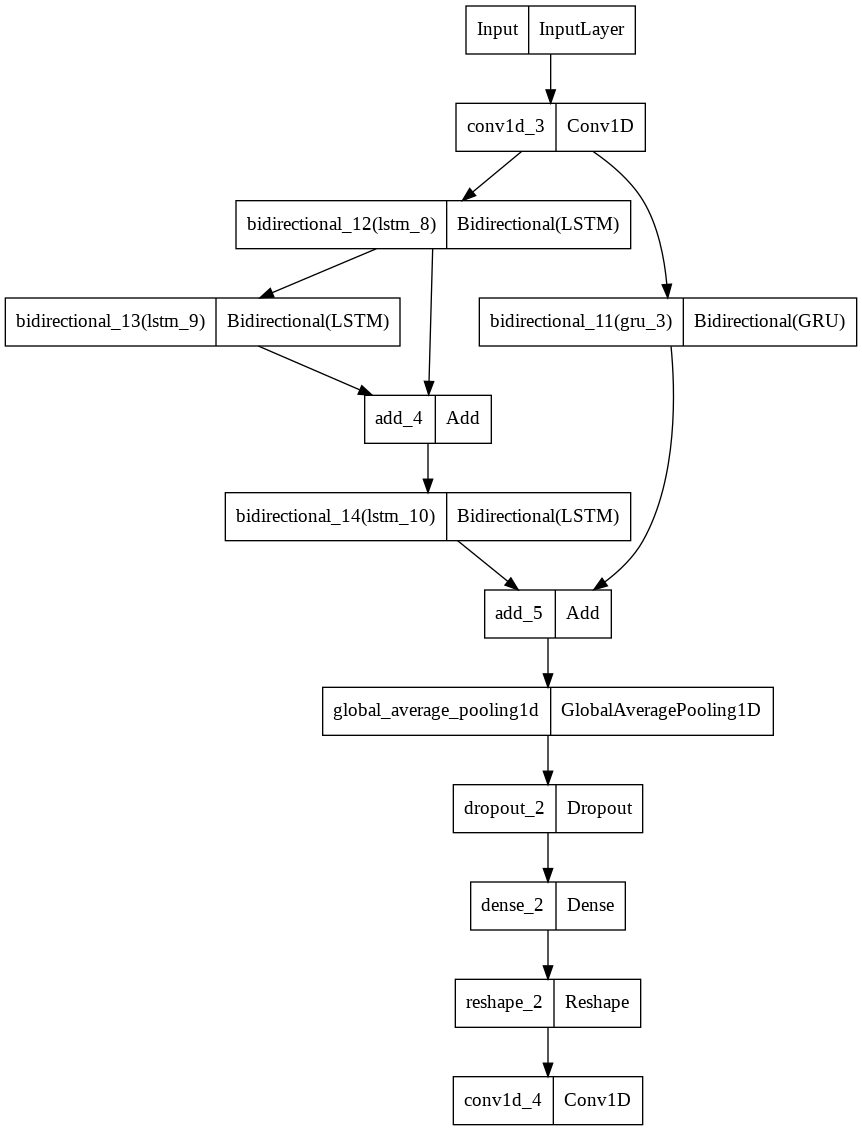

In [ ]:
model = build_model(input_shape, output_shape)
model.summary()
tf.keras.utils.plot_model(model)

In [ ]:
# Train the model
history = model.fit(
    x = X_train,
    y = y_train,
    batch_size = batch_size,
    epochs = epochs,
    validation_split=.1,
    callbacks = [
        tfk.callbacks.EarlyStopping(monitor='val_loss', mode='min', patience=10, restore_best_weights=True),
        tfk.callbacks.ReduceLROnPlateau(monitor='val_loss', mode='min', patience=5, factor=0.5, min_lr=1e-5)
    ]
).history

Epoch 1/200
97/97 [==============================] - 91s 722ms/step - loss: 0.1845 - mae: 0.3468 - val_loss: 0.0802 - val_mae: 0.2281 - lr: 0.0010
Epoch 2/200
97/97 [==============================] - 73s 749ms/step - loss: 0.0433 - mae: 0.1544 - val_loss: 0.0271 - val_mae: 0.1202 - lr: 0.0010
Epoch 3/200
97/97 [==============================] - 67s 694ms/step - loss: 0.0226 - mae: 0.1101 - val_loss: 0.0227 - val_mae: 0.1112 - lr: 0.0010
Epoch 4/200
97/97 [==============================] - 67s 694ms/step - loss: 0.0191 - mae: 0.1023 - val_loss: 0.0219 - val_mae: 0.1126 - lr: 0.0010
Epoch 5/200
97/97 [==============================] - 66s 684ms/step - loss: 0.0179 - mae: 0.0987 - val_loss: 0.0204 - val_mae: 0.1059 - lr: 0.0010
Epoch 6/200
97/97 [==============================] - 68s 699ms/step - loss: 0.0158 - mae: 0.0938 - val_loss: 0.0189 - val_mae: 0.1019 - lr: 0.0010
Epoch 7/200
97/97 [==============================] - 66s 686ms/step - loss: 0.0148 - mae: 0.0903 - val_loss: 0.0184 - 

### Save the model

In [ ]:
model.save("LSTNet")

In [ ]:
model = tf.keras.models.load_model("Model.hdf5")

In [ ]:
# Autoregressive Forecasting
X = tf.constant(dataset) # This is NOT for submit
X = X.numpy()
future = X[-window:]
X_min = X.min(axis=0)
X_max = X.max(axis=0)
future = (future-X_min)/(X_max-X_min)
future = np.expand_dims(future,0)
pred_horizon = 864
out = np.array([])
for i in range(0, pred_horizon, telescope):
    current_prediction = model.predict(future)
    if(len(out) == 0):
        out = current_prediction
    else:
        out = np.concatenate((out,current_prediction),axis=1)
    future = np.concatenate((future[:,telescope:,:],current_prediction), axis=1)
out = np.squeeze(out,0)
out = out * (X_max - X_min) + X_min
# out = tf.convert_to_tensor(out)

In [ ]:
future = X[-window:]
future = np.expand_dims(future,0)

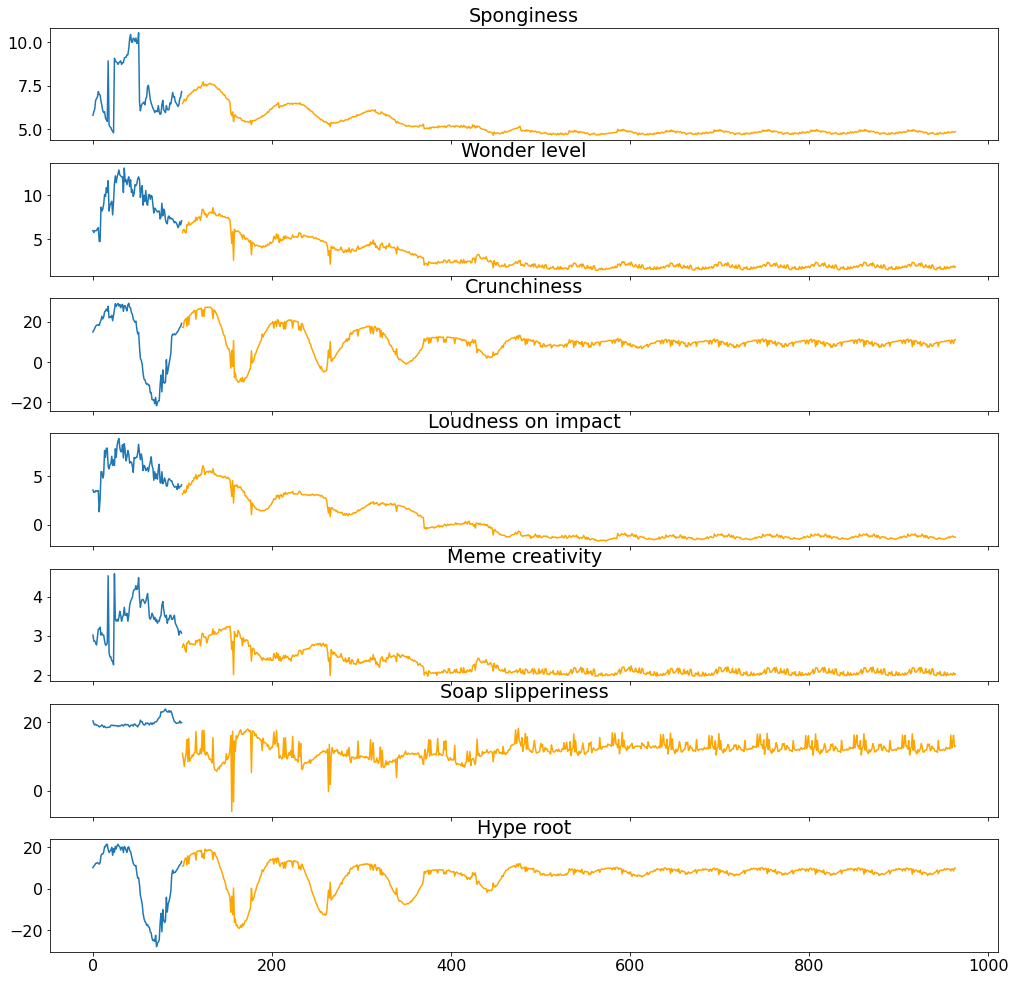

In [ ]:
figs, axs = plt.subplots(len(target_labels), 1, sharex=True, figsize=(17,17))
for i, col in enumerate(target_labels):
    axs[i].plot(np.arange(len(future[0,:,i])), future[0,:,i])
    axs[i].plot(np.arange(len(future[0,:,i]), len(future[0,:,i])+pred_horizon), out[:,i], color='orange')
    axs[i].set_title(col)
    # axs[i].set_ylim(0,1)
plt.show()